In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

/home/ozkan.aydemir-umw/miniconda3/envs/rapids_singlecell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
import anndata as ad
import wget

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [7]:
os.makedirs("./h5",exist_ok=True)

In [8]:
wget.download('https://figshare.com/ndownloader/files/45788454',
              "./h5/adata.raw.h5ad")
wget.download('https://scverse-exampledata.s3.eu-west-1.amazonaws.com/rapids-singlecell/dli_census.h5ad',
              "h5/dli_census.h5ad")


100% [......................................................................] 885572153 / 885572153

'h5/dli_census.h5ad'

In [9]:
data_load_start = time.time()

In [10]:
%%time
adata = sc.read("h5/dli_census.h5ad")

CPU times: user 11.6 s, sys: 963 ms, total: 12.5 s
Wall time: 12.6 s


In [12]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 577 ms, sys: 1.68 s, total: 2.26 s
Wall time: 2.47 s


In [11]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 30.644334316253662


In [13]:
preprocess_start = time.time()


In [14]:
preprocess_start = time.time()


In [15]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 5.01 ms, sys: 8 μs, total: 5.01 ms
Wall time: 4.7 ms


In [16]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 3.84 ms, sys: 0 ns, total: 3.84 ms
Wall time: 3.73 ms


In [17]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 915 ms, sys: 81.9 ms, total: 997 ms
Wall time: 2.93 s


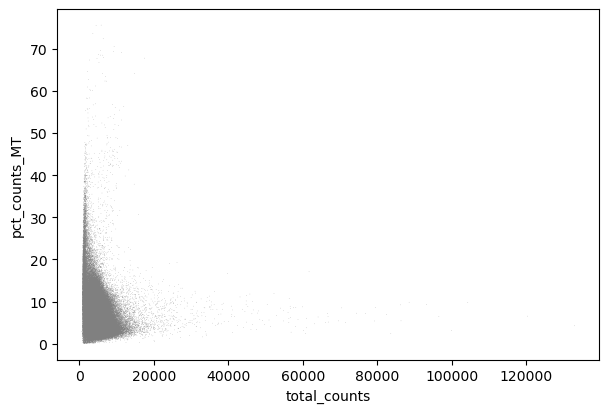

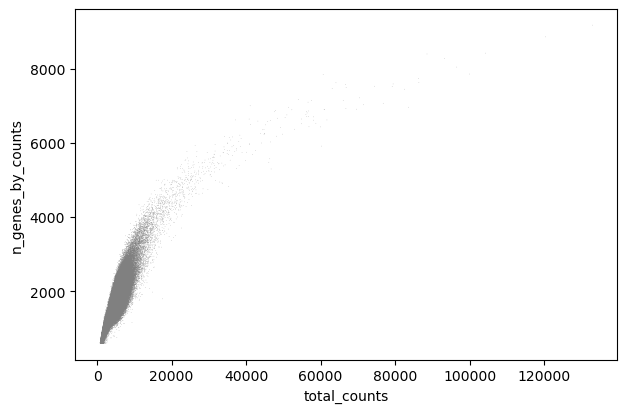

In [18]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

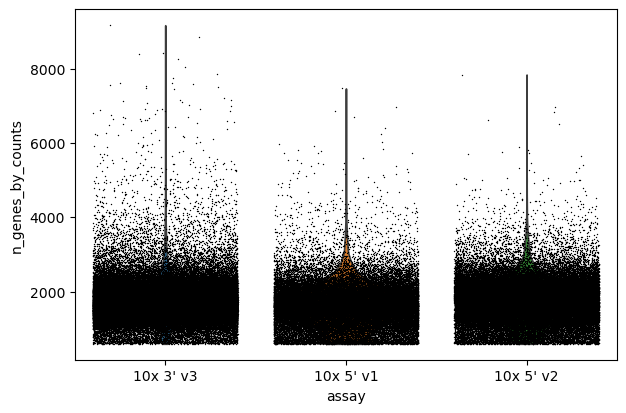

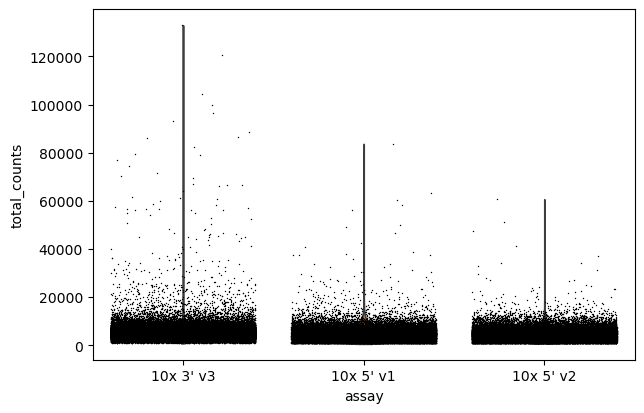

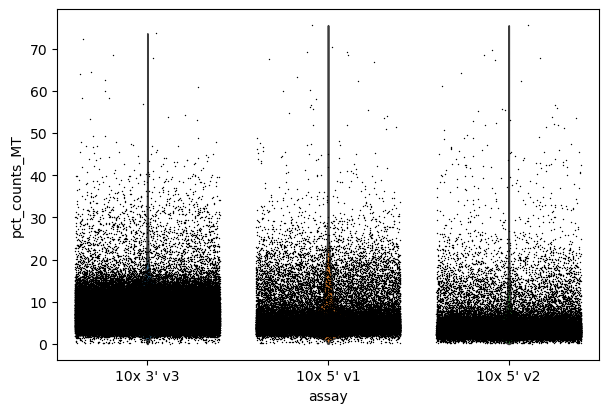

In [19]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="assay")

In [20]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["pct_counts_MT"] < 20]

CPU times: user 395 ms, sys: 20.1 ms, total: 415 ms
Wall time: 416 ms


In [50]:
adata

AnnData object with n_obs × n_vars = 213081 × 5000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'log1p_total_counts_RIBO', 'louvain', 'leiden', 'louvain_harmony', 'leiden_harmony'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs',

In [21]:
%%time
rsc.pp.filter_genes(adata, min_cells=3)

CPU times: user 4.32 s, sys: 477 ms, total: 4.79 s
Wall time: 9.71 s


In [22]:
adata.shape

(213081, 25430)

In [23]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 47.2 ms, sys: 2.95 ms, total: 50.1 ms
Wall time: 79.1 ms


In [24]:
%%time
rsc.pp.log1p(adata)

CPU times: user 17.5 ms, sys: 7.28 ms, total: 24.7 ms
Wall time: 24.2 ms


In [25]:
%%time
rsc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor="cell_ranger")

CPU times: user 567 ms, sys: 29.1 ms, total: 596 ms
Wall time: 947 ms


In [26]:
%%time
rsc.pp.filter_highly_variable(adata)

CPU times: user 400 ms, sys: 12.1 ms, total: 412 ms
Wall time: 412 ms


In [27]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 1.29 s, sys: 356 ms, total: 1.64 s
Wall time: 3 s


In [28]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 2.76 s, sys: 326 ms, total: 3.09 s
Wall time: 3.49 s


In [29]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 156.0653419494629


In [30]:
%%time
rsc.tl.pca(adata, n_comps=100)

CPU times: user 2.06 s, sys: 149 ms, total: 2.21 s
Wall time: 3.83 s


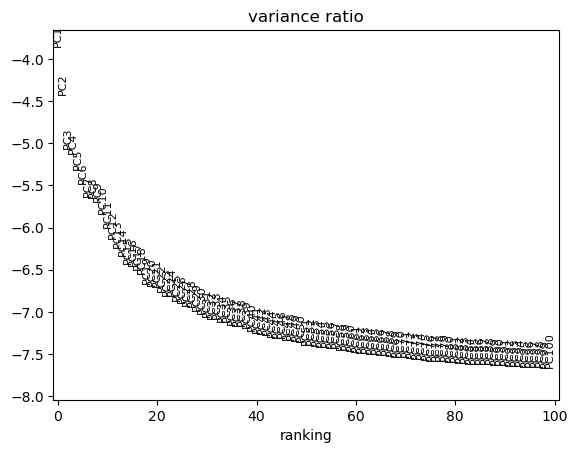

In [31]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

In [32]:
rsc.get.anndata_to_CPU(adata)

In [33]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 3.98 s, sys: 344 ms, total: 4.32 s
Wall time: 5.54 s


In [34]:
%%time
rsc.tl.umap(adata)

CPU times: user 652 ms, sys: 54.6 ms, total: 706 ms
Wall time: 1.17 s


In [35]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 1.69 s, sys: 1.68 s, total: 3.37 s
Wall time: 12.5 s


In [36]:
%%time
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 973 ms, sys: 1.43 s, total: 2.4 s
Wall time: 3.29 s


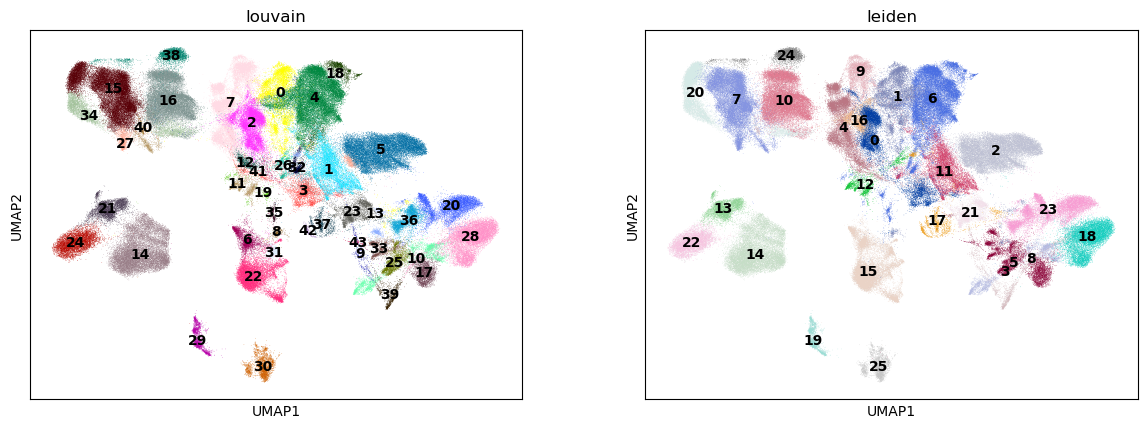

CPU times: user 2.23 s, sys: 31 ms, total: 2.26 s
Wall time: 2.28 s


In [37]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

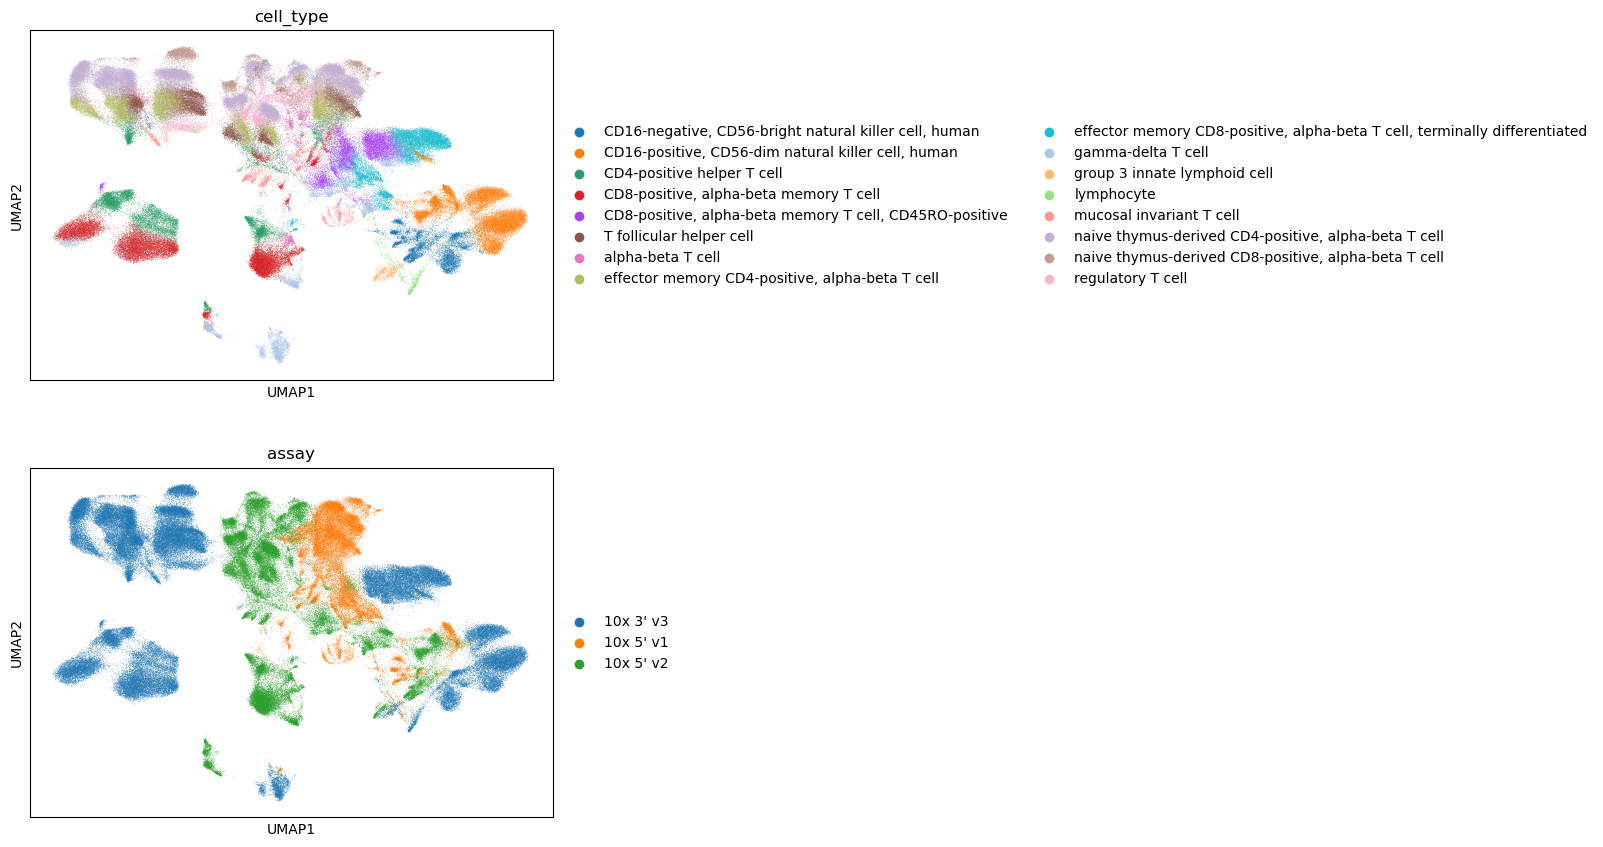

In [38]:
sc.pl.umap(adata, color=["cell_type", "assay"],ncols=1,)

In [39]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [40]:
%%time
rsc.pp.harmony_integrate(adata, key="assay", dtype=cp.float32)

CPU times: user 11.7 s, sys: 836 ms, total: 12.6 s
Wall time: 15.4 s


In [41]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")

CPU times: user 3.1 s, sys: 392 ms, total: 3.49 s
Wall time: 3.49 s


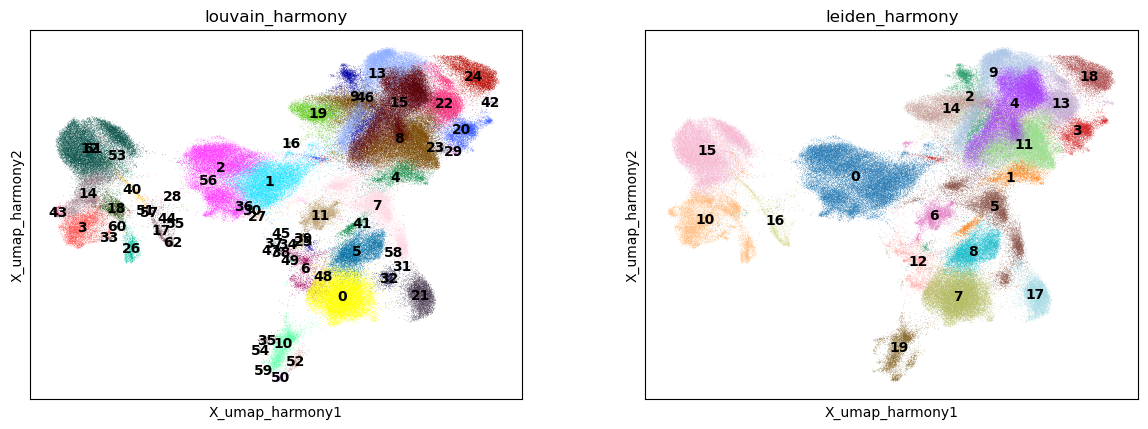

CPU times: user 2.16 s, sys: 20.2 ms, total: 2.18 s
Wall time: 2.18 s


In [42]:
%%time
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

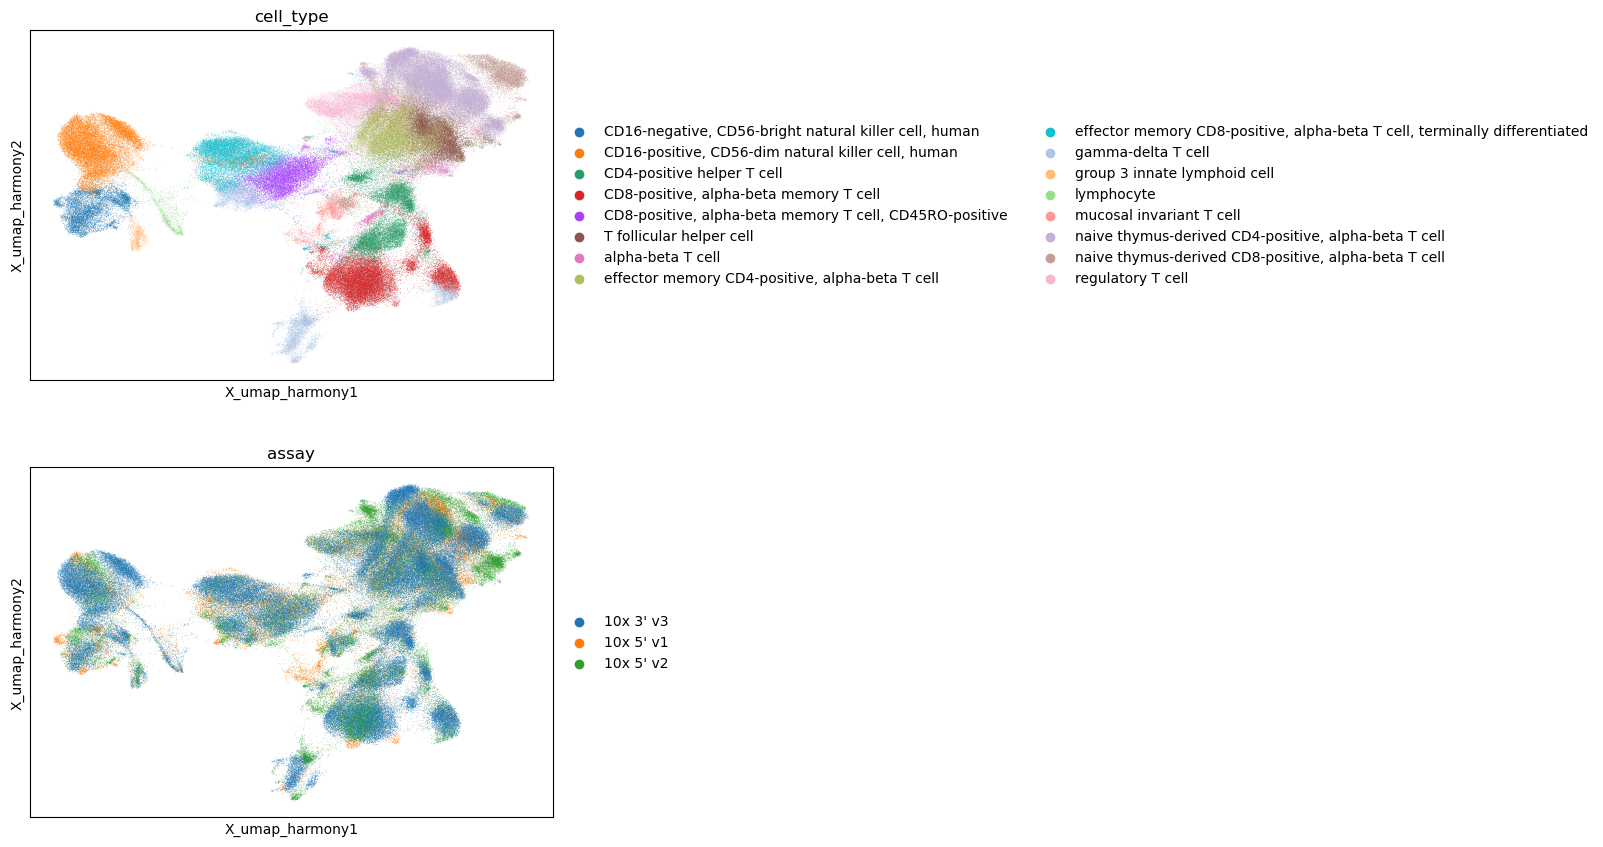

In [43]:
sc.pl.embedding(adata,basis="X_umap_harmony", color=["cell_type", "assay"], ncols=1)

In [44]:
%%time
rsc.tl.tsne(adata, n_pcs=40, perplexity=30, early_exaggeration=12, learning_rate=200, use_rep="X_pca_harmony")

[2025-10-30 14:24:51.078] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 3.38 s, sys: 1.93 s, total: 5.31 s
Wall time: 5.42 s


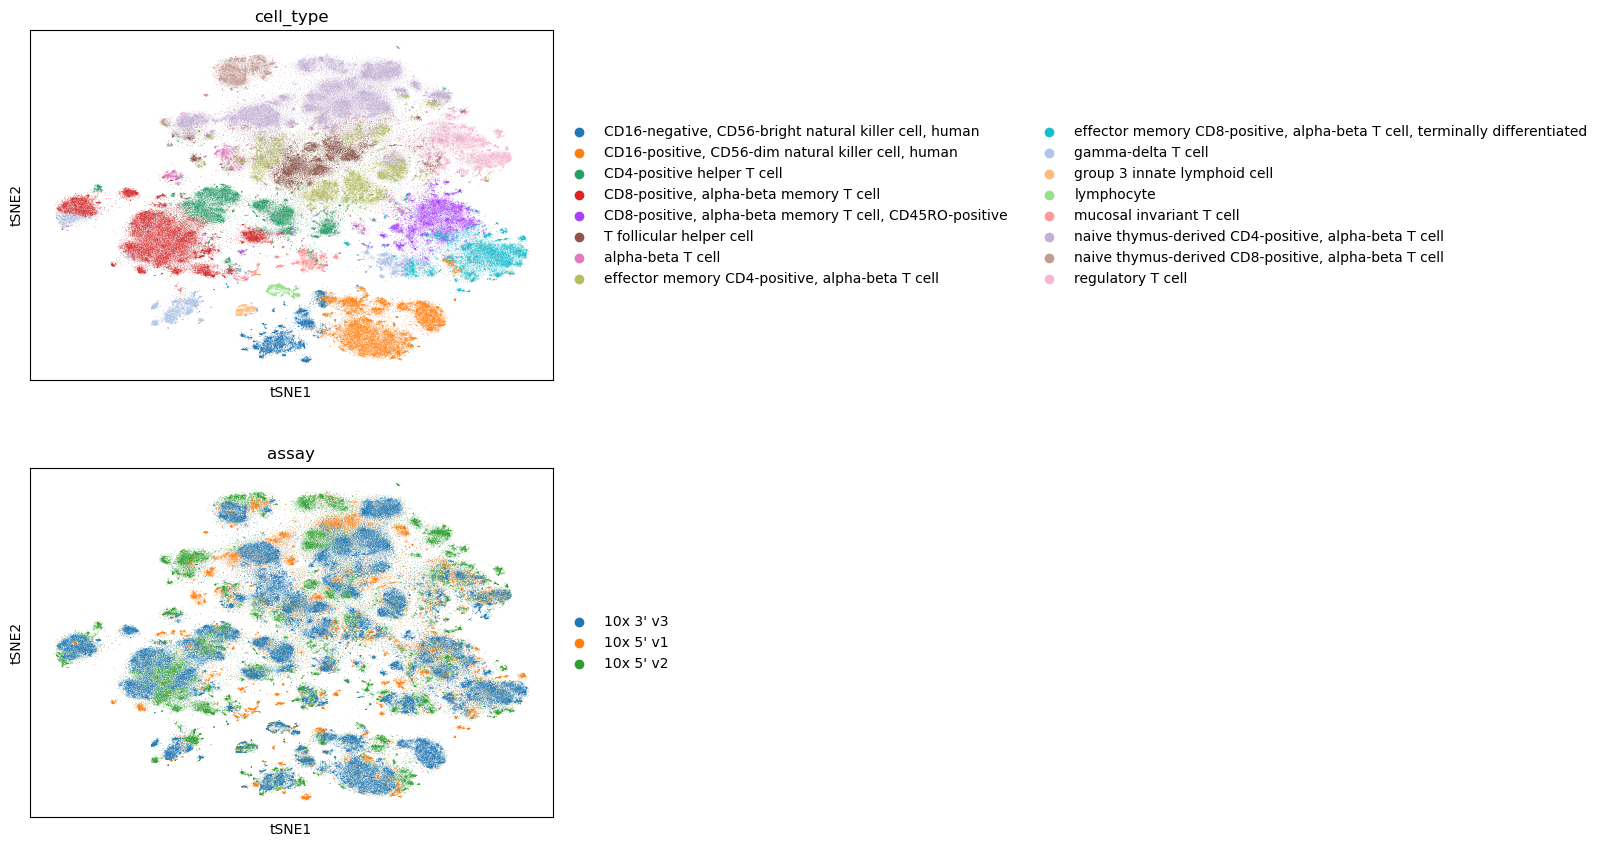

In [45]:
sc.pl.tsne(adata, color=["cell_type", "assay"], ncols=1)